📌 In this notebook, our main goal is to categorize product reviews into two distinct categories: positive and negative. To achieve this goal, we use various techniques of natural language processing and machine learning to analyze and classify the emotions expressed in the notebook accurately.

# Import Necessary Libraries

In [1]:
#!pip install nltk
#!pip install textblob
#!pip install wordcloud
#

from warnings import filterwarnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.preprocessing import LabelEncoder
from textblob import Word, TextBlob
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
#import pr curve
from sklearn.metrics import precision_recall_curve
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
#nltk.download('omw-1.4') #si la cel·la 15 no funciona descomentar aixo

filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: '%.2f' % x)

#SVM - Support Vector Machine
from sklearn.svm import SVC

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidmarti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidmarti/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/davidmarti/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import Dataset

In [2]:

import os
# Obtener el directorio actual del script
directorio_script = os.path.dirname(os.path.abspath(os.getcwd()))

# Construir la ruta al archivo CSV
ruta_csv_data = os.path.join(directorio_script, 'data', 'amazon_reviews.csv')


df = pd.read_csv(ruta_csv_data, sep=",")

#Eliminació de columnes innecesaries
df = df.drop('helpful_yes', axis=1)
df = df.drop('helpful_no', axis=1)
df = df.drop('total_vote', axis=1)
df = df.drop('score_pos_neg_diff', axis=1)
df = df.drop('score_average_rating', axis=1)
df = df.drop('wilson_lower_bound', axis=1)

df.head()

,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff
0,0,NaN,4.00,No issues.,2014-07-23,138
1,1,0mie,5.00,"Purchased this for my device, it worked as adv...",2013-10-25,409
2,2,1K3,4.00,it works as expected. I should have sprung for...,2012-12-23,715
3,3,1m2,5.00,This think has worked out great.Had a diff. br...,2013-11-21,382
4,4,2&amp;1/2Men,5.00,"Bought it with Retail Packaging, arrived legit...",2013-07-13,513


# Text Processing

In [3]:
def text_preprocessing(dataframe, dependent_var):
  # Normalizing Case Folding - Uppercase to Lowercase
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

  # Removing Punctuation
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('[^\w\s]','')

  # Removing Numbers
  dataframe[dependent_var] = dataframe[dependent_var].str.replace('\d','')

  # StopWords
  sw = stopwords.words('english')
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

  # Remove Rare Words
  temp_df = pd.Series(' '.join(dataframe[dependent_var]).split()).value_counts()
  drops = temp_df[temp_df <= 1]
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join(x for x in str(x).split() if x not in drops))

  # Lemmatize
  dataframe[dependent_var] = dataframe[dependent_var].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

  return dataframe

In [4]:
df = text_preprocessing(df, "reviewText")

In [5]:
df["reviewText"].head()

0                                                issue
1    purchased device worked advertised never much ...
2    work expected higher capacity think made bit e...
3    think worked gb card went south one held prett...
4    bought retail packaging arrived legit envelope...
Name: reviewText, dtype: object

# Text Visualization

In [6]:
def text_visulaization(dataframe, dependent_var, barplot=True, wordcloud=True):
  # Calculation of Term Frequencies
  tf = dataframe[dependent_var].apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
  tf.columns = ["Paraules", "Freqüència"]
  # print("Total de paraules que només apareixen 1 cop: ",tf[tf["Freqüència"]==1].shape[0])
  # print(tf.loc[tf["Freqüència"] == 1, "Paraules"].tolist())
  if barplot:
    # Bar Plot
    tf[tf["Freqüència"]>1000].plot.barh(x="Paraules", y="Freqüència")
    plt.title("Calcul de Freqüències de Termes (>1000): Bar Plot")
    plt.show()

  if wordcloud:
    # WordCloud
    text = " ".join(i for i in dataframe[dependent_var])
    wordcloud = WordCloud(max_font_size=100, max_words=1000, background_color="white").generate(text)
    plt.figure(figsize=[10, 10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Calcul de Freqüències de Termes : wordcloud")
    plt.show()
    wordcloud.to_file("wordcloud.png")


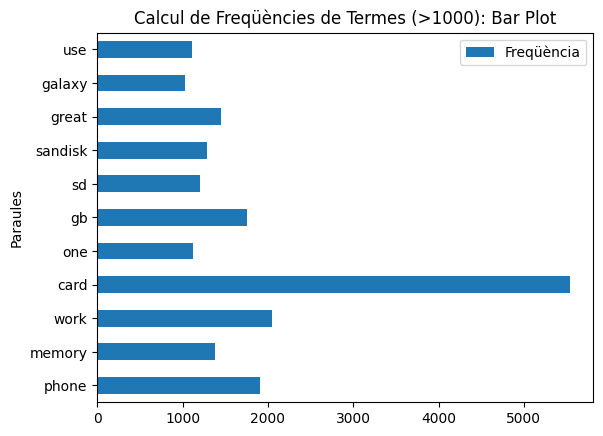

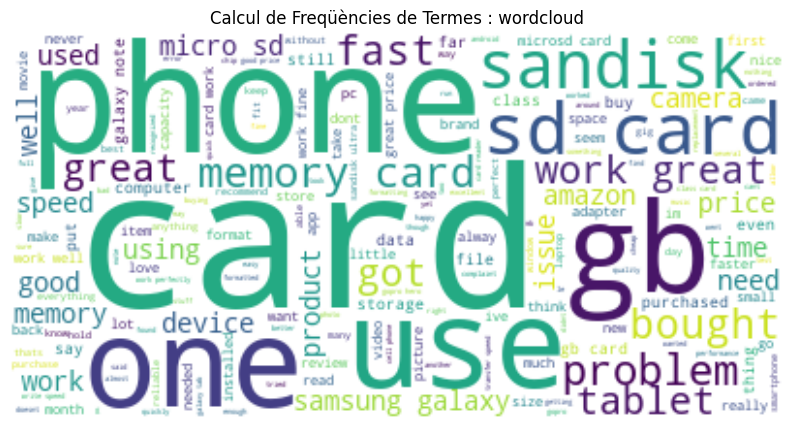

In [7]:
text_visulaization(df, "reviewText")

# Feature Engineering

In [8]:
# Función para asignar valores a una nueva columna según la condición
def asignar_valor(score):
    if score in [1, 2, 3]:
        return 'neg'
    elif score in [4, 5]:
        return 'pos'
    else:
        return None  # Manejo de otros valores si los hay

# Aplicar la función a la columna 'score' para crear una nueva columna 'nueva_columna'
df['label'] = df['overall'].apply(asignar_valor)

# Mostrar el DataFrame resultante
df


,Unnamed: 0,reviewerName,overall,reviewText,reviewTime,day_diff,label
0,0,NaN,4.00,issue,2014-07-23,138,pos
1,1,0mie,5.00,purchased device worked advertised never much ...,2013-10-25,409,pos
2,2,1K3,4.00,work expected higher capacity think made bit e...,2012-12-23,715,pos
3,3,1m2,5.00,think worked gb card went south one held prett...,2013-11-21,382,pos
4,4,2&amp;1/2Men,5.00,bought retail packaging arrived legit envelope...,2013-07-13,513,pos
...,...,...,...,...,...,...,...
4910,4910,"ZM ""J""",1.00,bought sandisk gb class use htc inspire month ...,2013-07-23,503,neg
4911,4911,Zo,5.00,used capability samsung galaxy note greatly ex...,2013-08-22,473,pos
4912,4912,Z S Liske,5.00,great card fast reliable come optional adapter...,2014-03-31,252,pos
4913,4913,Z Taylor,5.00,good amount space stuff want fit gopro say,2013-09-16,448,pos


In [9]:
def grafic_distribucions():
    subset = df[df['label'].isin(['pos', 'neg'])]
    conteo = subset['label'].value_counts()

    #Grafic
    plt.figure(figsize=(5, 5))
    plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['red', 'orange'])
    plt.title('Distribució de valors pos i neg')
    plt.axis('equal')  
    plt.show()
    #valors col 'overall'
    conteo = df['overall'].value_counts()

    # Grafic
    plt.figure(figsize=(5, 5))
    plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90)
    plt.title('Distribució de valors a la columna "overall"')
    plt.axis('equal')  
    plt.show()

    X = df["reviewText"]
    y = df['label']
    return X, y



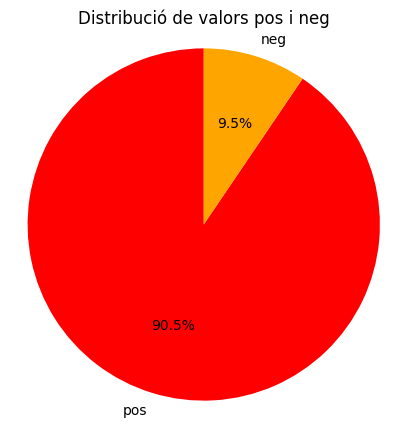

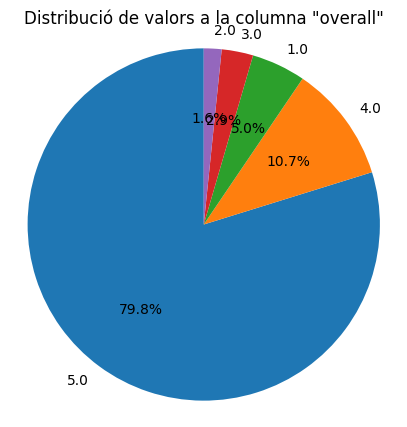

In [10]:
X, y = grafic_distribucions()

In [11]:
# Split Dataset
def split_dataset(dataframe, X, y):
  train_x, test_x, train_y, test_y = train_test_split(X, y, random_state=1)
  return train_x, test_x, train_y, test_y

In [12]:
train_x, test_x, train_y, test_y = split_dataset(df, X, y)

In [13]:
#Transforma Text data a numeric data
def create_features_count(train_x, test_x):
  # Count Vectors
  vectorizer = CountVectorizer(ngram_range=(1, 1))
  x_train_count_vectorizer = vectorizer.fit_transform(train_x)
  x_test_count_vectorizer = vectorizer.fit_transform(test_x)

  return x_train_count_vectorizer, x_test_count_vectorizer

In [14]:
x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)

In [15]:
def create_features_TFIDF_word(train_x, test_x):
  # TF-IDF word
  tf_idf_word_vectorizer = TfidfVectorizer()
  x_train_tf_idf_word = tf_idf_word_vectorizer.fit_transform(train_x)
  x_test_tf_idf_word = tf_idf_word_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_word, x_test_tf_idf_word

In [16]:
x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)

In [17]:
def create_features_TFIDF_ngram(train_x, test_x):
  # TF-IDF ngram
  tf_idf_ngram_vectorizer = TfidfVectorizer(ngram_range=(2,3))
  x_train_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(train_x)
  x_test_tf_idf_ngram = tf_idf_ngram_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_ngram, x_test_tf_idf_ngram

In [18]:
x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)

In [19]:
def create_features_TFIDF_chars(train_x, test_x):
  # TF-IDF Characters
  tf_idf_chars_vectorizer = TfidfVectorizer(analyzer="char", ngram_range=(2,3))
  x_train_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(train_x)
  x_test_tf_idf_chars = tf_idf_chars_vectorizer.fit_transform(test_x)

  return x_train_tf_idf_chars, x_test_tf_idf_chars

In [20]:
x_train_tf_idf_chars, x_test_tf_idf_chars = create_features_TFIDF_chars(train_x, test_x)

# Sentiment Modeling - Create Model

In [21]:
# Create a results df to store the results of each model
results_df = pd.DataFrame(columns=["Model", "Vectorizer", "Accuracy", "Precision", "Recall", "F1 Score", "Roc Auc Area"])

In [22]:
# Logistic Regression

def crate_model_logistic(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  loj_count = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
  loj_model_count = loj_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  precission_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='precision_macro').mean()
  recall_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='recall_macro').mean()  
  f1_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_count = cross_val_score(loj_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='roc_auc').mean()
  precision, recall, thresholds = precision_recall_curve(test_y, loj_model_count.predict_proba(x_test_count_vectorizer)[:,1])
  # plor pr curve
  plt.plot(precision, recall, label="Logistic Regression")
  #store results
  results_df.loc[len(results_df)] = ["Logistic Regression", "Count", accuracy_count, precission_count, recall_count, f1_count, roc_auc_count, pr_curve_count]

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  loj_word = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
  loj_model_word = loj_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  precission_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='precision_macro').mean()
  recall_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='recall_macro').mean()
  f1_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='roc_auc').mean()
  pr_curve_word = cross_val_score(loj_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='pr_curve').mean()
  #store results
  results_df.loc[len(results_df)] = ["Logistic Regression", "TF-IDF Word", accuracy_word, precission_word, recall_word, f1_word, roc_auc_word, pr_curve_word]

  # TF-IDF Ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  loj_ngram = LogisticRegression(solver='lbfgs', max_iter=1000, class_weight='balanced')
  loj_model_ngram = loj_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  precission_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision_macro').mean()
  recall_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall_macro').mean()
  f1_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='roc_auc').mean()
  pr_curve_ngram = cross_val_score(loj_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='pr_curve').mean()
  #store results
  results_df.loc[len(results_df)] = ["Logistic Regression", "TF-IDF Ngram", accuracy_ngram, precission_ngram, recall_ngram, f1_ngram, roc_auc_ngram, pr_curve_ngram]

  #print(results_df)
  
  print(results_df)
  return loj_model_count, loj_model_word, loj_model_ngram

In [23]:
loj_model_count, loj_model_word, loj_model_ngram = crate_model_logistic(train_x, test_x)

InvalidParameterError: The 'scoring' parameter of check_scoring must be a str among {'adjusted_rand_score', 'adjusted_mutual_info_score', 'precision', 'mutual_info_score', 'roc_auc_ovr_weighted', 'roc_auc_ovr', 'top_k_accuracy', 'neg_mean_gamma_deviance', 'recall_macro', 'recall_samples', 'neg_mean_poisson_deviance', 'roc_auc', 'neg_mean_squared_error', 'fowlkes_mallows_score', 'neg_brier_score', 'jaccard_weighted', 'f1', 'f1_weighted', 'recall_micro', 'neg_mean_absolute_percentage_error', 'v_measure_score', 'rand_score', 'positive_likelihood_ratio', 'f1_micro', 'normalized_mutual_info_score', 'max_error', 'precision_micro', 'average_precision', 'neg_log_loss', 'neg_mean_absolute_error', 'f1_samples', 'neg_negative_likelihood_ratio', 'precision_weighted', 'recall', 'precision_macro', 'f1_macro', 'homogeneity_score', 'jaccard_macro', 'jaccard_samples', 'neg_median_absolute_error', 'explained_variance', 'completeness_score', 'balanced_accuracy', 'recall_weighted', 'precision_samples', 'roc_auc_ovo_weighted', 'jaccard', 'matthews_corrcoef', 'accuracy', 'neg_root_mean_squared_error', 'neg_mean_squared_log_error', 'r2', 'roc_auc_ovo', 'jaccard_micro'}, a callable or None. Got 'pr_curve' instead.

In [ ]:
# Random Forest
def create_model_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_count = RandomForestClassifier(class_weight='balanced')
  rf_model_count = rf_count.fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
  precission_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='precision_macro').mean()
  recall_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='recall_macro').mean()
  f1_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='roc_auc').mean()
  pr_curve_count = cross_val_score(rf_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='pr_curve').mean()
  
  #store results
  results_df.loc[len(results_df)] = ["Random Forest", "Count", accuracy_count, precission_count, recall_count, f1_count, roc_auc_count, pr_curve_count]

  # TF-IDF Word
  x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
  rf_word = RandomForestClassifier(class_weight='balanced')
  rf_model_word = rf_word.fit(x_train_tf_idf_word, train_y)
  accuracy_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
  precission_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='precision_macro').mean()
  recall_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='recall_macro').mean()
  f1_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='roc_auc').mean()
  pr_curve_word = cross_val_score(rf_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='pr_curve').mean()
  #store results
  results_df.loc[len(results_df)] = ["Random Forest", "TF-IDF Word", accuracy_word, precission_word, recall_word, f1_word, roc_auc_word, pr_curve_word]

  # TF-IDF Ngram
  x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
  rf_ngram = RandomForestClassifier(class_weight='balanced')
  rf_model_ngram = rf_ngram.fit(x_train_tf_idf_ngram, train_y)
  accuracy_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
  precission_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision_macro').mean()
  recall_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall_macro').mean()
  f1_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()
  roc_auc_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='roc_auc').mean()
  pr_curve_ngram = cross_val_score(rf_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='pr_curve').mean()
  #store results
  results_df.loc[len(results_df)] = ["Random Forest", "TF-IDF Ngram", accuracy_ngram, precission_ngram, recall_ngram, f1_ngram, roc_auc_ngram, pr_curve_ngram]


  #print(results_df)
  print(results_df)


  return rf_model_count, rf_model_word, rf_model_ngram

In [24]:
rf_model_count, rf_model_word, rf_model_ngram = create_model_randomforest(train_x, test_x)

NameError: name 'crate_model_randomforest' is not defined

In [25]:
# Naive Bayes
def create_model_naivebayes(train_x, test_x):
    # Count
    x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
    nb_count = MultinomialNB()
    nb_model_count = nb_count.fit(x_train_count_vectorizer, train_y)
    accuracy_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
    precission_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='precision_macro').mean()
    recall_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='recall_macro').mean()
    f1_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_count = cross_val_score(nb_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='pr_curve').mean()

    #store results
    results_df.loc[len(results_df)] = ["Naive Bayes", "Count", accuracy_count, precission_count, recall_count, f1_count, roc_auc_count, pr_curve_count]
    
    # TF-IDF Word
    x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
    nb_word = MultinomialNB()
    nb_model_word = nb_word.fit(x_train_tf_idf_word, train_y)
    accuracy_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
    precission_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='precision_macro').mean()
    recall_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='recall_macro').mean()
    f1_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_word = cross_val_score(nb_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='pr_curve').mean()
    #store results
    results_df.loc[len(results_df)] = ["Naive Bayes", "TF-IDF Word", accuracy_word, precission_word, recall_word, f1_word, roc_auc_word, pr_curve_word]

    # TF-IDF Ngram
    x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
    nb_ngram = MultinomialNB()
    nb_model_ngram = nb_ngram.fit(x_train_tf_idf_ngram, train_y)
    accuracy_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
    precission_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision_macro').mean()
    recall_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall_macro').mean()
    f1_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_ngram = cross_val_score(nb_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='pr_curve').mean()
    #store results
    results_df.loc[len(results_df)] = ["Naive Bayes", "TF-IDF Ngram", accuracy_ngram, precission_ngram, recall_ngram, f1_ngram, roc_auc_ngram, pr_curve_ngram]

    #print(results_df)
    print(results_df)

    return nb_model_count, nb_model_word, nb_model_ngram


In [26]:
nb_model_count, nb_model_word, nb_model_ngram = create_model_naivebayes(train_x, test_x)

InvalidParameterError: The 'scoring' parameter of check_scoring must be a str among {'adjusted_rand_score', 'adjusted_mutual_info_score', 'precision', 'mutual_info_score', 'roc_auc_ovr_weighted', 'roc_auc_ovr', 'top_k_accuracy', 'neg_mean_gamma_deviance', 'recall_macro', 'recall_samples', 'neg_mean_poisson_deviance', 'roc_auc', 'neg_mean_squared_error', 'fowlkes_mallows_score', 'neg_brier_score', 'jaccard_weighted', 'f1', 'f1_weighted', 'recall_micro', 'neg_mean_absolute_percentage_error', 'v_measure_score', 'rand_score', 'positive_likelihood_ratio', 'f1_micro', 'normalized_mutual_info_score', 'max_error', 'precision_micro', 'average_precision', 'neg_log_loss', 'neg_mean_absolute_error', 'f1_samples', 'neg_negative_likelihood_ratio', 'precision_weighted', 'recall', 'precision_macro', 'f1_macro', 'homogeneity_score', 'jaccard_macro', 'jaccard_samples', 'neg_median_absolute_error', 'explained_variance', 'completeness_score', 'balanced_accuracy', 'recall_weighted', 'precision_samples', 'roc_auc_ovo_weighted', 'jaccard', 'matthews_corrcoef', 'accuracy', 'neg_root_mean_squared_error', 'neg_mean_squared_log_error', 'r2', 'roc_auc_ovo', 'jaccard_micro'}, a callable or None. Got 'pr_curve' instead.

In [27]:
# SVM
def create_model_svm(train_x, test_x, kernel_type="linear", degree=3, gamma="auto"):
    # Count
    x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
    svm_count = SVC(kernel=kernel_type)
    svm_model_count = svm_count.fit(x_train_count_vectorizer, train_y)
    accuracy_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10).mean()
    precission_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='precision_macro').mean()
    recall_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='recall_macro').mean()
    f1_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_count = cross_val_score(svm_model_count, x_test_count_vectorizer, test_y, cv=10, scoring='pr_curve').mean()
    #matriz de confusion
    #from sklearn.metrics import confusion_matrix
    #y_pred = svm_model_count.predict(x_test_count_vectorizer)
    #confusion_matrix(test_y, y_pred)
    
    #store results
    results_df.loc[len(results_df)] = ["SVM", "Count", accuracy_count, precission_count, recall_count, f1_count, roc_auc_count, pr_curve_count]

    # TF-IDF Word
    x_train_tf_idf_word, x_test_tf_idf_word = create_features_TFIDF_word(train_x, test_x)
    svm_word = SVC(kernel=kernel_type)
    svm_model_word = svm_word.fit(x_train_tf_idf_word, train_y)
    accuracy_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10).mean()
    precission_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='precision_macro').mean()
    recall_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='recall_macro').mean()
    f1_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_word = cross_val_score(svm_model_word, x_test_tf_idf_word, test_y, cv=10, scoring='pr_curve').mean()
    #store results
    results_df.loc[len(results_df)] = ["SVM", "TF-IDF Word", accuracy_word, precission_word, recall_word, f1_word, roc_auc_word, pr_curve_word]

    # TF-IDF Ngram
    x_train_tf_idf_ngram, x_test_tf_idf_ngram = create_features_TFIDF_ngram(train_x, test_x)
    svm_ngram = SVC(kernel=kernel_type)
    svm_model_ngram = svm_ngram.fit(x_train_tf_idf_ngram, train_y)
    accuracy_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10).mean()
    precission_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='precision_macro').mean()
    recall_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='recall_macro').mean()
    f1_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='f1_macro').mean()
    roc_auc_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='roc_auc').mean()
    pr_curve_ngram = cross_val_score(svm_model_ngram, x_test_tf_idf_ngram, test_y, cv=10, scoring='pr_curve').mean()
    #store results
    results_df.loc[len(results_df)] = ["SVM", "TF-IDF Ngram", accuracy_ngram, precission_ngram, recall_ngram, f1_ngram, roc_auc_ngram, pr_curve_ngram]

    #print(results_df)
    print(results_df)
    
    return svm_model_count, svm_model_word, svm_model_ngram

In [28]:
svm_model_count, svm_model_word, svm_model_ngram= create_model_svm(train_x, test_x)

InvalidParameterError: The 'scoring' parameter of check_scoring must be a str among {'adjusted_rand_score', 'adjusted_mutual_info_score', 'precision', 'mutual_info_score', 'roc_auc_ovr_weighted', 'roc_auc_ovr', 'top_k_accuracy', 'neg_mean_gamma_deviance', 'recall_macro', 'recall_samples', 'neg_mean_poisson_deviance', 'roc_auc', 'neg_mean_squared_error', 'fowlkes_mallows_score', 'neg_brier_score', 'jaccard_weighted', 'f1', 'f1_weighted', 'recall_micro', 'neg_mean_absolute_percentage_error', 'v_measure_score', 'rand_score', 'positive_likelihood_ratio', 'f1_micro', 'normalized_mutual_info_score', 'max_error', 'precision_micro', 'average_precision', 'neg_log_loss', 'neg_mean_absolute_error', 'f1_samples', 'neg_negative_likelihood_ratio', 'precision_weighted', 'recall', 'precision_macro', 'f1_macro', 'homogeneity_score', 'jaccard_macro', 'jaccard_samples', 'neg_median_absolute_error', 'explained_variance', 'completeness_score', 'balanced_accuracy', 'recall_weighted', 'precision_samples', 'roc_auc_ovo_weighted', 'jaccard', 'matthews_corrcoef', 'accuracy', 'neg_root_mean_squared_error', 'neg_mean_squared_log_error', 'r2', 'roc_auc_ovo', 'jaccard_micro'}, a callable or None. Got 'pr_curve' instead.

# Visualització de resultats

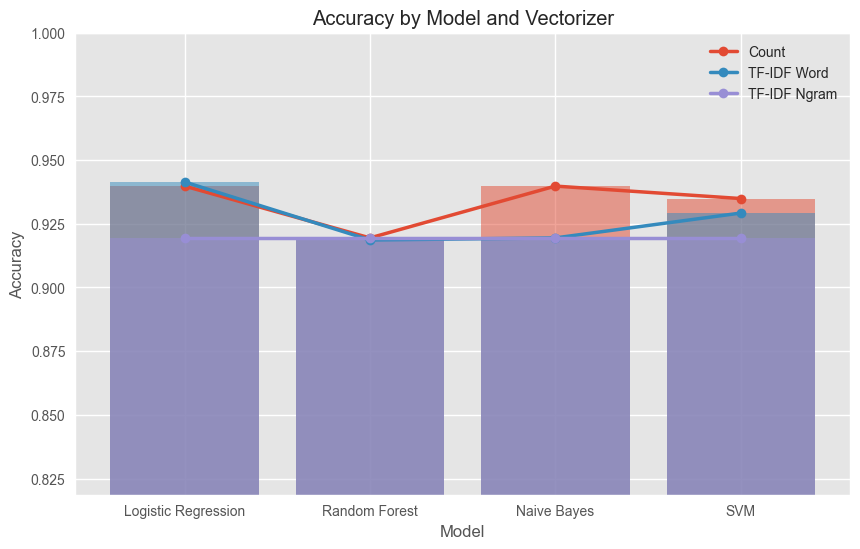

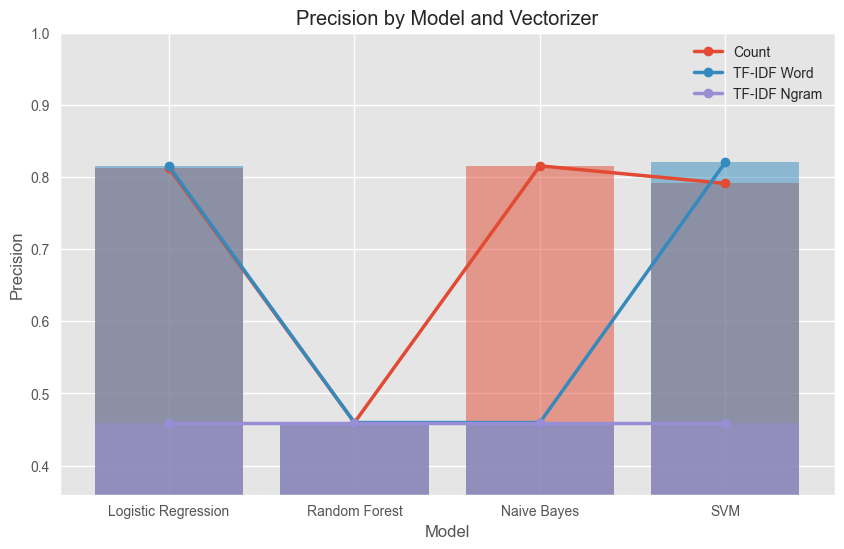

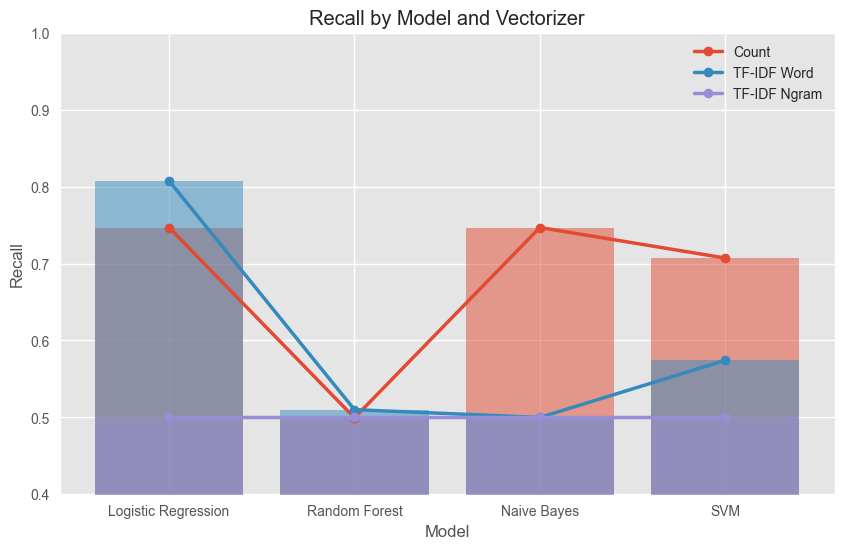

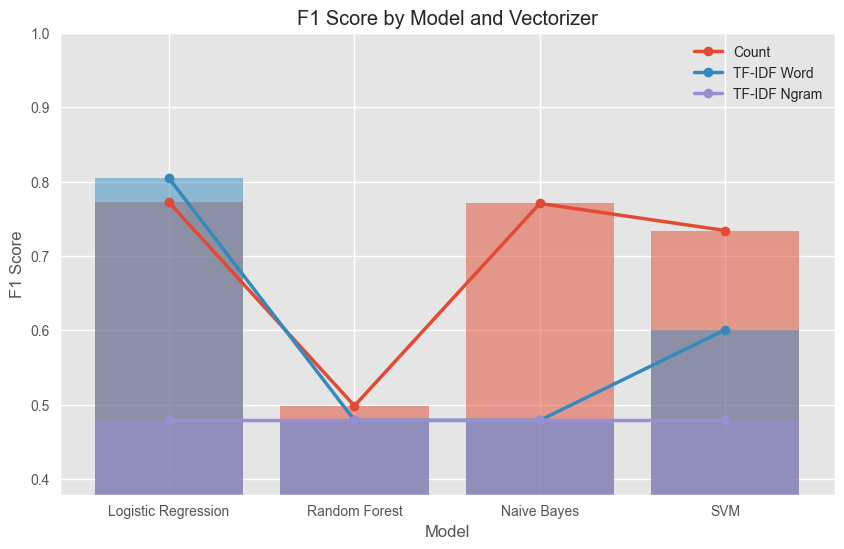

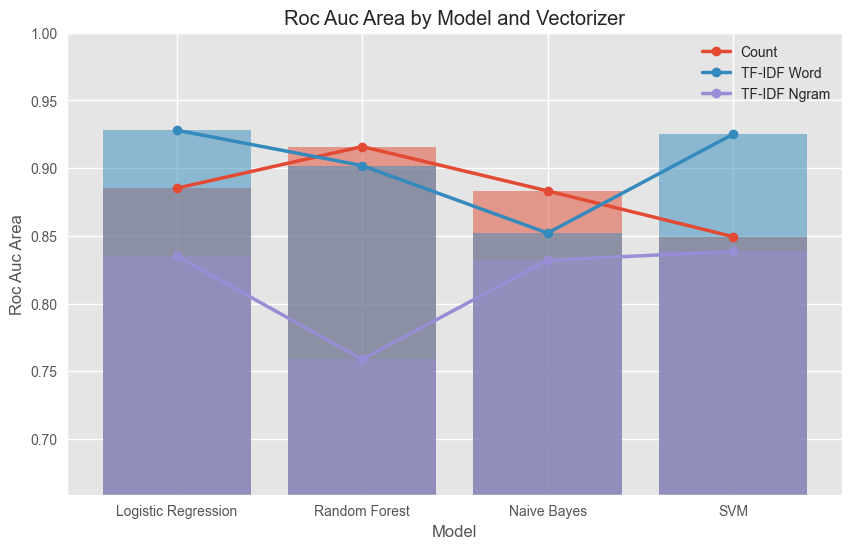

In [120]:
import matplotlib.pyplot as plt

#Accuracy
def plot_results(results_df, parameter='Accuracy'):
    # Filter the results dataframe for the required columns
    filtered_results = results_df[['Model', 'Vectorizer', parameter]]

    # Get unique values in the Vectorizer column
    vectorizers = filtered_results['Vectorizer'].unique()

    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the accuracy for each model and vectorizer using bars and lines
    for vectorizer in vectorizers:
        model_accuracy = filtered_results[filtered_results['Vectorizer'] == vectorizer]
        plt.plot(model_accuracy['Model'], model_accuracy[parameter], marker='o', label=vectorizer)
        plt.bar(model_accuracy['Model'], model_accuracy[parameter], alpha=0.5)

    # Set the title and labels for the plot
    plt.title(parameter+' by Model and Vectorizer')
    plt.xlabel('Model')
    plt.ylabel(parameter)

    # Set the y limit between 0.1 lower than the minimum value and 1
    plt.ylim([filtered_results[parameter].min() - 0.1, 1])

    # Add a legend to the plot
    plt.legend()

    # Style the plot using blue, red and green
    plt.style.use('ggplot')

    # Apply black contourn to the lines
    plt.rcParams['lines.linewidth'] = 2.5

    # Save the plot as a png file
    plt.savefig(parameter+'_by_Model_and_Vectorizer.png')

    # Show the plot
    plt.show()

parameters = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'Roc Auc Area']
def plot_all(results_df):
    for parameter in parameters:
        plot_results(results_df, parameter)
plot_all(results_df)

# Model Tuning

In [94]:
def model_tuning_randomforest(train_x, test_x):
  # Count
  x_train_count_vectorizer, x_test_count_vectorizer = create_features_count(train_x, test_x)
  rf_model_count = RandomForestClassifier(random_state=1)
  rf_params = {"max_depth": [2,5,8, None],
               "max_features": [2,5,8, "auto"],
               "n_estimators": [100,500,1000],
               "min_samples_split": [2,5,10]}
  rf_best_grid = GridSearchCV(rf_model_count, rf_params, cv=10, n_jobs=-1, verbose=False).fit(x_train_count_vectorizer, train_y)
  rf_model_count_final = rf_model_count.set_params(**rf_best_grid.best_params_, random_state=1).fit(x_train_count_vectorizer, train_y)
  accuracy_count = cross_val_score(rf_model_count_final, x_test_count_vectorizer, test_y, cv=10).mean()
  print("Accuracy - Count Vectors: %.3f" % accuracy_count)

  return rf_model_count_final

In [95]:
rf_model_count_final = model_tuning_randomforest(train_x, test_x)

KeyboardInterrupt: 

# Prediction

In [ ]:
def predict_count(train_x, model, new_comment):
  new_comment= pd.Series(new_comment)
  new_comment = CountVectorizer().fit(train_x).transform(new_comment)
  result = model.predict(new_comment)
  if result==1:
    print("Comment is Positive")
  else:
    print("Comment is Negative")

In [ ]:
# Logistic Regression
predict_count(train_x, model=loj_model_count, new_comment="I think it is a good product")

Comment is Positive


In [ ]:
# Random Forest
predict_count(train_x, model=rf_model_count, new_comment="I don't think it is bad")

NameError: name 'rf_model_count' is not defined

In [ ]:
# Sample Review
new_comment=pd.Series(df["reviewText"].sample(1).values)
new_comment

0    bought samsung galaxy first came onto market w...
dtype: object

In [ ]:
# Sample Review - Random Forest
predict_count(train_x, model=rf_model_count, new_comment=new_comment)

Comment is Positive
